# Detecting ripples from Neuralynx NSC files (2023-01-19 JJS)

## Import Packages

In [10]:
import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
from scipy import stats
from scipy.stats import zscore
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/u/home/j/jsakon/johnModules')
# new for loading .mat and .edf
from scipy import stats,signal,io
import time
import mat73 # this loads .mat files as dicts
import neuralynx_io
import warnings # neuralynx_io gives annoying warnings but seems to work fine
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ripple Detection

Firstly, generate macro data using the files in the subject directory.

In [17]:
# path = '/u/project/ifried/data/free_recall/Hagar_movie_data/'
path = '/u/home/j/jsakon/neuroLoad/data/'


# each pair will be subtracted for bipolar referencing


fns = [
    ['LAH1_0005.ncs','LAH2_0005.ncs'],
    ['LAH1_0005-Copy1.ncs','LAH2_0005-.ncs']
    ]

macro_mat = []
for fn in fns:
    macro_ncs1 = neuralynx_io.load_ncs(path+fn[0])
    macro_ncs2 = neuralynx_io.load_ncs(path+fn[1])
    macro_mat = superVstack(macro_mat,macro_ncs1['data']-macro_ncs2['data'])
    
sr = int(macro_ncs1['header']['SamplingFrequency']) # 2000 for NLX macro

np.shape(macro_mat)
sr

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2169344 and the array at index 1 has size 57602048

Initialize some key variables

In [12]:
# # Ensure indices are within bounds, simulate inserting NaNs within the bounds
# start_index = int(1e7)  # Example start index
# end_index = int(1.2e7)  # Example end index, ensure this is within the data range
# macro_mat[:, start_index:end_index] = np.nan

# # Plotting
# x_values = np.arange(macro_mat.shape[1])  # Generating x-axis values corresponding to columns
# plt.figure(figsize=(10, 5))
# plt.plot(x_values, macro_mat[0, :], linestyle='-', marker='', markersize=2)  # Using empty marker
# plt.title("Visualization of NaN Gaps")
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.grid(True)

# # # Optionally, set x-limits to focus on the area of interest
# # plt.xlim([start_index - 50000, end_index + 50000])  # Adjust these values as needed to focus on the NaN area

# plt.show()


In [18]:
from ptsa.data.timeseries import TimeSeries
import mne
from scipy.signal import firwin,filtfilt,kaiserord
# import pingouin as pg
%autoreload

save_values = 0

recall_type_switch = 0

remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###

min_ripple_rate = 0.1 # Hz. # 0.1 for hamming
max_ripple_rate = 1.5 # Hz. # 1.5 for hamming
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them # 0.05 for hamming
max_electrode_by_electrode_correlation = 0.2 #??? # 0.2 for hamming

filter_type = 'hamming' # see local version below for details 
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

Next, preprocess and filter the macro data

In [20]:
np.shape(macro_mat)

(2169344,)

In [19]:
# Turn data into PTSA structure
time_in_sec = np.linspace(1, np.shape(macro_mat)[1], np.shape(macro_mat)[1]) / sr
eeg_ptsa = TimeSeries(np.expand_dims(macro_mat, axis=0), # need event dimension for conversion to MNE later
                dims=('event','channel', 'time'),
                coords={'event':[0], # so can keep it 3d
                        'channel':np.arange(np.shape(macro_mat)[0]),
                        'time':time_in_sec,
                        'samplerate':sr})

# line removal...don't do 120 for now (I never see any line noise there for whatever reason)
eeg_ptsa = ButterworthFilter(freq_range=[58.,62.], filt_type='stop', order=4).filter(timeseries=eeg_ptsa)
eeg_ptsa = ButterworthFilter(freq_range=[178.,182.], filt_type='stop', order=4).filter(timeseries=eeg_ptsa)


# let's save HFA too
HFA_freqs = np.logspace(np.log10(64),np.log10(178),10)
HFA_eeg = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[118.,122.], filt_type='stop', order=4).filter()
HFA_eeg = ButterworthFilter(timeseries=HFA_eeg, freq_range=0.5, filt_type='highpass',order=4).filter() 
HFA_morlet = MorletWaveletFilter(timeseries=HFA_eeg, freqs=HFA_freqs, output='power', width=5, verbose=True).filter()

# # now can remove buffers
# sr_factor = 1000/sr
# HFA_morlet = HFA_morlet[:,:,:,int(eeg_buffer/sr_factor):int(np.shape(HFA_morlet)[3]-(eeg_buffer/sr_factor))]
HFA_morlet = xarray.ufuncs.log10(HFA_morlet, out=HFA_morlet.values) # 10 x events x channels x time
# resample down to 10 Hz (100 ms bins)

HFA_morlet = ResampleFilter(timeseries=HFA_morlet,resamplerate=10).filter() # axes are freqs (10) X words X pairs X bins after downsample
#         # zscore across events & time bins # doing it differently now after talking to Mike 2022-03-08
#         HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(HFA_morlet, axis=(1,3)) 

IndexError: tuple index out of range

In [5]:
# # z-score using std of time bin averaged instead (mean is same either way)
# HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(np.mean(HFA_morlet, axis=3),axis=1)
# HFA_morlet = np.mean(HFA_morlet,0) # mean over the 10 frequencies (now down to events X pairs X 100 ms bins)

# without events I think we just average over time (axis 2)
HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=2)) / np.std(np.mean(HFA_morlet, axis=2),axis=1)
HFA_morlet = np.mean(HFA_morlet,0) # mean over the 10 frequencies (now down to events X pairs X 100 ms bins)



## FILTERS ##
trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
# That is, the frequency is expressed as a fraction of the Nyquist frequency.
ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
# formula from Belanger's Digital Processing of Signals
# see https://dsp.stackexchange.com/questions/31066/how-many-taps-does-an-fir-filter-need for how to use

# if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P @@
#     ntaps = np.ceil(ntaps)
nyquist = sr/2        

# filter for ripples using filter selected above
if filter_type == 'hamming':
    # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA  
    FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')               
    #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg minus bandstopped signal            
    eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
    bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED            
    eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)
    ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
    kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')            
elif filter_type == 'butter':
    eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
    eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
    time_length = np.shape(eeg_rip_band)[2]/int(sr/1000)
    eeg_raw = ptsa_to_mne(eeg_ptsa,[0,time_length]) #[0,psth_end-psth_start+2*eeg_buffer])    #**  
#         eeg_ptsa = None # clear variable # no reason to do this in local version...really for cluster
elif filter_type == 'staresina':
    FIR_bandstop_star = firwin(241, [80.,100.], fs=sr, window='hamming',pass_zero='bandstop') # order = 3*80+1               
    eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop_star,1.,eeg_ptsa)

if filter_type is not 'staresina':
    time_length = np.shape(eeg_rip_band)[2]/int(sr/1000)
    eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,time_length]) #[0,psth_end-psth_start+2*eeg_buffer]) #** 
    _ = eeg_rip_band.apply_hilbert(envelope=True)
    eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,time_length]) #[0,psth_end-psth_start+2*eeg_buffer]) #** 
    _ = eeg_ied_band.apply_hilbert(envelope=True)

In [9]:
eeg_ptsa = TimeSeries(np.expand_dims(macro_mat, axis=0), # need event dimension for conversion to MNE later
                dims=('event','channel', 'time'),
                coords={'event':[0], # so can keep it 3d
                        'channel':np.arange(np.shape(macro_mat)[0]),
                        'time':time_in_sec,
                        'samplerate':sr})
eeg_ptsa = ButterworthFilter(freq_range=[58.,62.], filt_type='stop', order=4).filter(timeseries=eeg_ptsa)
eeg_ptsa = ButterworthFilter(freq_range=[178.,182.], filt_type='stop', order=4).filter(timeseries=eeg_ptsa)

eeg_ptsa

<xarray.TimeSeries (event: 1, channel: 2, time: 14400512)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * event       (event) int64 0
  * channel     (channel) int64 0 1
  * time        (time) float64 0.0005 0.001 0.0015 ... 7.2e+03 7.2e+03 7.2e+03
    samplerate  int64 2000

Finally, construct the ripple array. This will contain the exact times of the ripple onsets as boolean values of 1

In [6]:
ripple_array = []
HFA_array = []

trial_by_trial_correlation = []
elec_by_elec_correlation = []
elec_ripple_rate_array = []
    
session_ripple_rate_by_elec = []

total_channel_ct = 0

for channel in range(np.shape(eeg_rip_band.get_data())[1]): # unpack number of channels
    print(f'Channel #{channel} of {np.shape(eeg_rip_band.get_data())[1]}')
    total_channel_ct+=1 # total channels before artifact removal
    
    if filter_type != 'staresina':
        # get data from MNE container 
        eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
        eeg_ied = eeg_ied_band.get_data()[:,channel,:]
    else:
        eeg_rip = eeg_rip_band[:,channel,:] # filtered signal still in PTSA format

    # select detection algorithm (note that iedlogic is same for both so always run that)
    if filter_type == 'hamming':
        # filter IEDs 
        eeg_ied = eeg_ied**2 # already rectified now square
        eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
        mean1 = np.mean(eeg_ied)
        std1 = np.std(eeg_ied)
        iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2019            
        # detect ripples
        ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
    elif filter_type == 'butter':
        eeg_mne = eeg_raw.get_data()[:,channel,:]
        # detect ripples
        ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)    
    elif filter_type == 'staresina':
        ripplelogic = detectRipplesStaresina(eeg_rip,sr)

    if filter_type == 'butter': # ^^^
        desired_sample_rate = 1000 # for Vaz algo

    if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
        ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
        
    # ripples are detected, so can remove buffers now #

    # if ripplelogic is just 1d (because it only has 1 "trial") it bugs out programs below
    if len(ripplelogic.shape) == 1: # if just detecting within a single vector
        ripplelogic = np.expand_dims(ripplelogic,axis=0)

    # skip this electrode if the ripple rate is below threshold
    temp_start_array,_ = getStartEndArrays(ripplelogic)
    elec_ripple_rate = np.sum(temp_start_array)/temp_start_array.shape[0]/(time_length/1000)
    
    if elec_ripple_rate < min_ripple_rate:
        print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
        continue
    elif elec_ripple_rate > max_ripple_rate:
        print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
        continue # skip this electrode

    # check the ripples for this electrode and make sure they're not super correlated across trials

    # first, bin the array so can get more realistic correlation not dependent on ms timing
    
    binned_ripplelogic = downsampleBinary(ripplelogic[:, :ripplelogic.size - ripplelogic.size%10],10) # downsample by 10x so 10 ms bins
    trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
    num_cols = len(list(trial_ripple_df))
    temp_tbt_corr = 0
    if num_cols > 1: # if more than 1 trial
        trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
        if sum(sum(trial_ripple_df))>1:
            temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
        else:
            temp_tbt_corr = 1    
        if temp_tbt_corr > max_trial_by_trial_correlation:
            print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
            continue

    ## if this electrode passes SAVE data ##

    trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
    elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode

    # append arrays across electrodes
    ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes

Channel #0 of 2


NameError: name 'sub' is not defined

In [ ]:
np.nanmean(eeg_rip)

Get start times for ripples

In [ ]:
temp_start_array.shape
elec_ripple_rate
np.sum(temp_start_array)/temp_start_array.shape[0]/(time_length/1000)

In [8]:
start_array_TEST,end_array = getStartEndArrays(ripple_array) # get start array
 
print('Got start_array with '+str(start_array.shape[0])+' trials!')

Got start_array with 2 trials!


In [9]:
np.shape(start_array)
np.sum(start_array,1)
np.sum(start_array,1)[0]/(np.shape(start_array)[1]/desired_sample_rate) # 500 Hz sampling
np.sum(start_array,1)[1]/(np.shape(start_array)[1]/desired_sample_rate)

(2, 3600128)

array([1473, 1734], dtype=uint64)

0.2045760595178838

0.24082477067482044

(<Figure size 2000x200 with 1 Axes>, <Axes: >)

Text(0.5, 0, 'Time from recall (s)')

Text(0, 0.5, 'Channel')

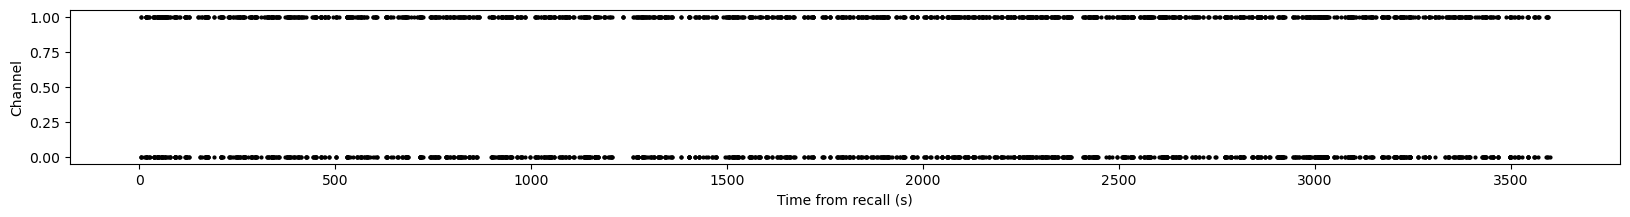

In [11]:
# plot raster
plt.subplots(1,1,figsize=(20,2))   
plt.scatter(np.where(start_array)[1]/1000,np.where(start_array)[0],s=4,color='k') # SWR time v. trial
plt.xlabel('Time from recall (s)')
plt.ylabel('Channel')
ax = plt.gca()